In [1]:
import matplotlib
from imshowpair import imshowpair
import matplotlib.pyplot as plt
import numpy as np
import os
from oiffile import imread
from PIL import Image
import random
import skimage
from skimage.transform import resize
import matplotlib
import glob
import torch
import sys
sys.path.insert(0, '..')
import scipy.io as sio
import matplotlib.patches as patches
from skimage.measure import label,regionprops
from matplotlib_scalebar.scalebar import ScaleBar
from skimage.transform import rescale
import dognet
import functions
from sklearn.metrics import roc_curve, auc
import os, os.path
%matplotlib inline
from skimage.draw import circle
from dognet.unet import *

In [3]:
#get training masks
path1 = glob.glob("../datasets/vermisA/trainingMasks/*.npy")
trainingMasks = functions.get_trainingMasks(path1)
#get and scale training images
path2 = glob.glob("../datasets/vermisA/trainingImages/*.npy")
trainingImages,collman = functions.get_trainingImages(path2,40,50,60)

rndsplit = np.random.permutation(len(trainingImages))
numTest = int(len(trainingImages)/4)
numTrain = int(len(trainingImages)-numTest)
imagestraining = rndsplit[:numTrain]
imagestesting = rndsplit[numTrain:]

newTrainingImages=[]
newTrainingMasks=[]
newTestingImages=[]
newTestingMasks=[]

for i in imagestraining:
    newTrainingImages.append(trainingImages[i])
    newTrainingMasks.append(trainingMasks[i])
for j in imagestesting:  
    newTestingImages.append(trainingImages[j])
    newTestingMasks.append(trainingMasks[j])

lossFn = "sd"
alpha = 0.5
gamma = 1
lrs = 1e-4
batchSize = 2
nEpoch = 1200
dschedule = [50,0.98]

device = torch.device('cuda')
net = UNet(3,2).to(device)
net,train_errors,test_errors,visual_test=dognet.train_routine(net,dognet.create_generator(newTrainingImages,newTrainingMasks,device = device,batch_size = batchSize),dognet.create_generator(newTestingImages,newTestingMasks,device = device,batch_size = batchSize,transform=False),n_train_samples = numTrain, n_test_samples=numTest,n_epoch=nEpoch,batch_size=batchSize,loss=lossFn,lr=lrs,alpha = alpha,decay_schedule = dschedule,gamma = gamma,device = device)



Training finished!


In [6]:
torch.save(net, 'vermisA405060')

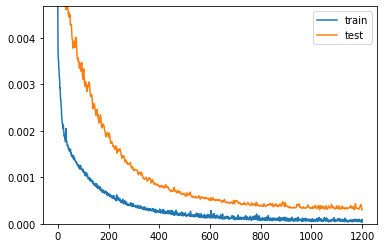

In [4]:
plt.plot(train_errors)
plt.plot(test_errors)
plt.ylim((0,max(train_errors)))
plt.legend(["train", "test"])
plt.show()


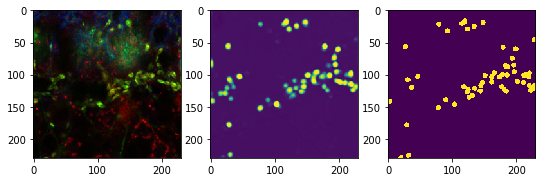

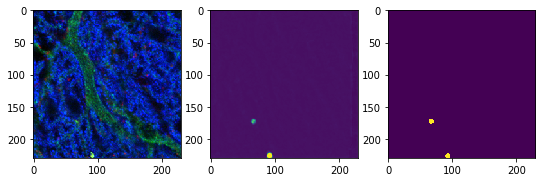

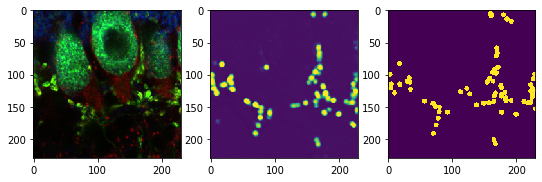

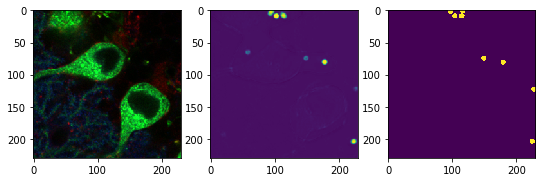

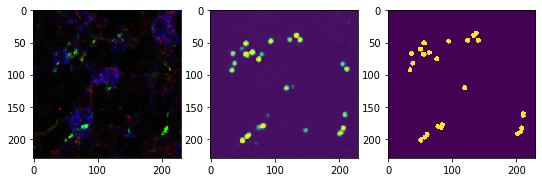

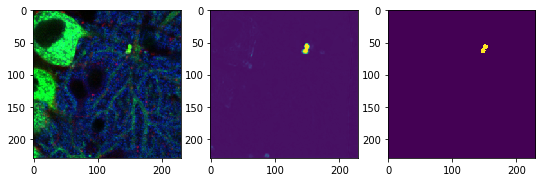

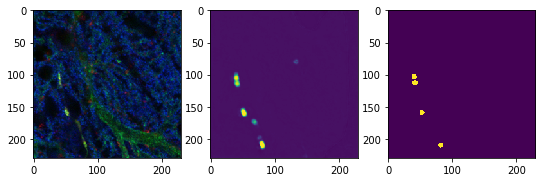

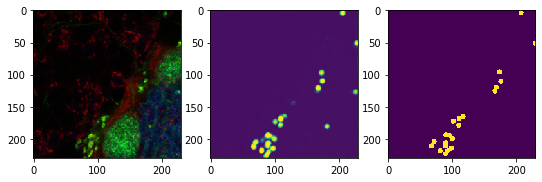

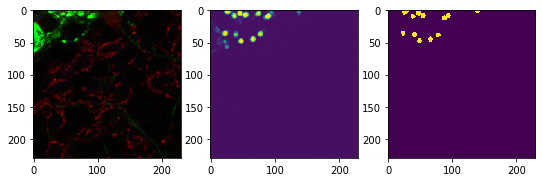

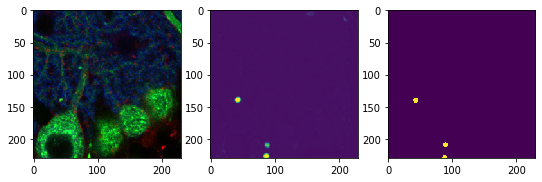

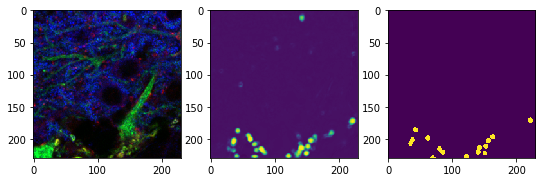

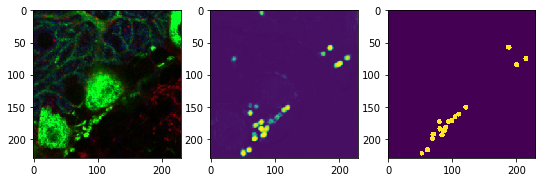

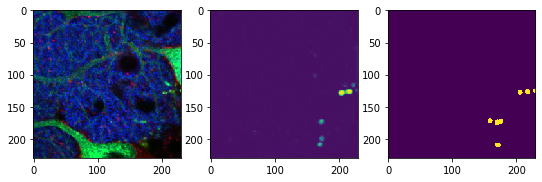

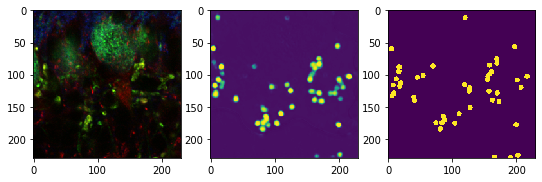

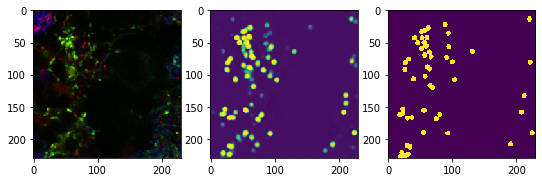

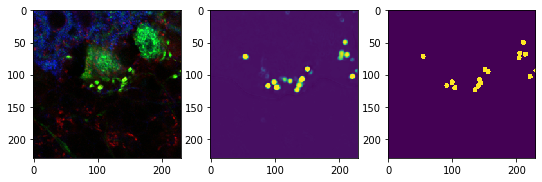

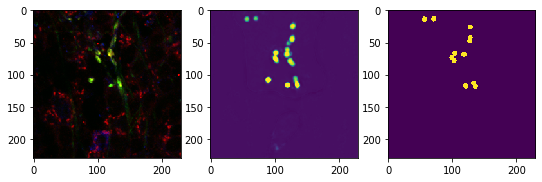

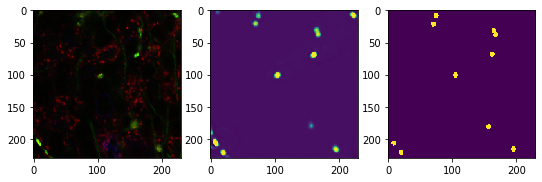

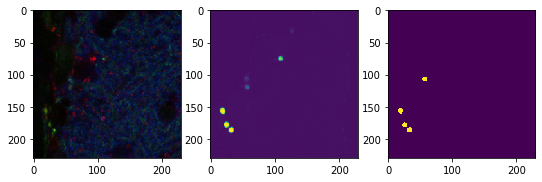

In [5]:
for selidx in range(0,numTest,2):
    if np.sum(newTestingMasks[selidx])>0:
        plt.figure(figsize=(9,3))
        inimg = np.transpose(resize(np.transpose(newTestingImages[selidx],(1,2,0)),(230,230)),(2,0,1))
        outimg = functions.inference(net.to(torch.device("cpu")),inimg,get_inter=False,device=torch.device("cpu"))
        plt.subplot(1,3,1)
        plt.imshow(np.clip(np.transpose(newTestingImages[selidx],(1,2,0)),0,1))
        plt.clim(0,1)
        plt.subplot(1,3,2)
        plt.imshow(outimg[0])
        plt.clim(0,1)
        plt.subplot(1,3,3)
        plt.imshow(newTestingMasks[selidx])
        plt.clim(0,1)
        plt.show()

In [52]:
newTestingImages[1].shape

(3, 230, 230)

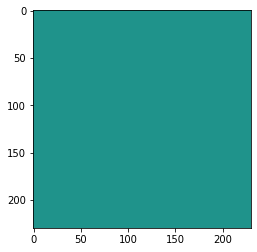

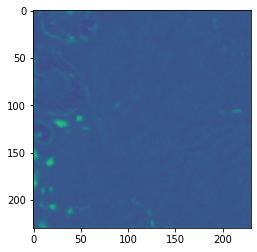

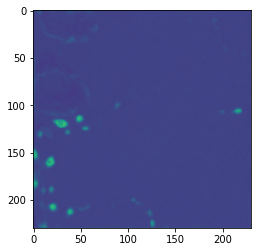

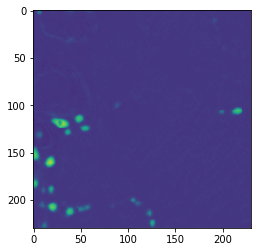

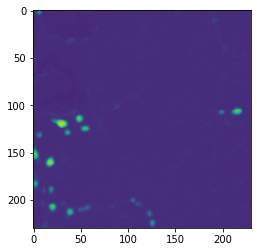

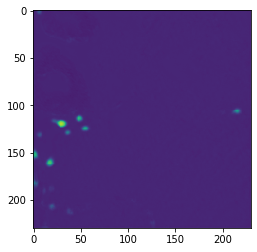

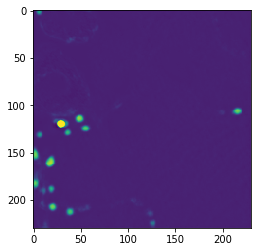

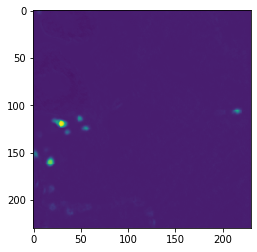

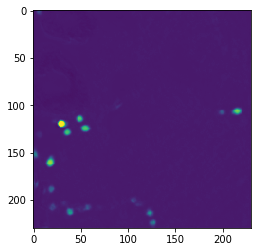

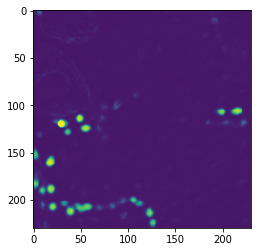

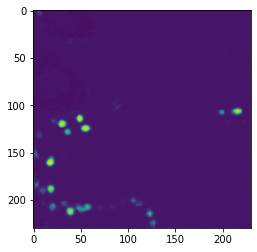

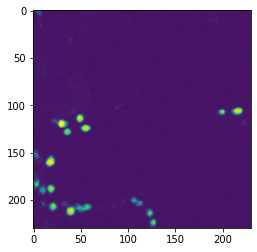

In [79]:
nums = np.arange(0,nEpoch,100)
for x in nums:
    plt.imshow(visual_test[x].detach().numpy())
    plt.clim(0,1)
    plt.show()

In [ ]:
import imageio

images=[]
for x in range(0, int(800/5)):
    images.append((visual_test[5*x].detach().numpy()))
imageio.mimsave('vermisA21images.gif', images, fps = 100)